# Modelagem para previsão de séries temporais

## Preparando o ambiente

Importando as bibliotecas que iremos usar nas análises.

In [1]:
# imports

import sys
import pickle
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics  

## Importando os dados

Fazendo a leitura dos dados no formato dataframe

In [2]:
df_acidentes = pd.read_csv('df_acidentes.csv', index_col=0) 

## Verificando o dataset

In [3]:
# Verificando as 5 primeiras linhas do dataset

df_acidentes.head()

,ocorrencias
data,
2015-06-01,39
2015-06-02,49
2015-06-03,46
2015-06-04,28
2015-06-05,40


In [4]:
# Verificando a quantidade de dados e número de variáveis

df_acidentes.shape

(1675, 1)

In [5]:
# Verificando como a variável "ocorrencias" está sendo interpretada

df_acidentes.dtypes

ocorrencias    int64
dtype: object

In [6]:
# Verificando como o index data está sendo interpretado
type(df_acidentes.index[0])

str

## Preparando a base de dados para a aplicação de modelos

Os métodos de Aprendizado de Máquina para previsão, em príncipio buscam descrever os dados sem o conhecimento profundo da distribuição dos mesmos, pois os algoritmos são responsáveis pelo ajuste automático. Essa característica pode ser interessante frente a modelos estatísticos. Por esse motivo, optou-se na exploração de técnicas de Aprendizado de Máquina.

Primeiramente, para a aplicação no modelo, criamos uma base de dados contendo as informações de número de acidentes dos dias t, t-1,..., t-n, com n = 30.

In [7]:
# Função para criar o dataset

def df_with_lag(serie, steps_in):
    features = pd.DataFrame()
    features['t'] = serie 
    for i in range(1, steps_in+1):
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:]
    return features

In [8]:
# Aplicando a função para n=30, os 30 dias anteriores para serem usados como entrada do modelo

steps_in = 30
data_features = df_with_lag(df_acidentes.ocorrencias, steps_in)

In [9]:
# Verificando o novo dataset

data_features.head()

,t,t-1,t-2,t-3,t-4,t-5,t-6,t-7,t-8,t-9,...,t-21,t-22,t-23,t-24,t-25,t-26,t-27,t-28,t-29,t-30
data,,,,,,,,,,,,,,,,,,,,,
2015-07-01,37,33.0,35.0,16.0,17.0,28.0,24.0,10.0,35.0,38.0,...,33.0,48.0,42.0,17.0,33.0,40.0,28.0,46.0,49.0,39.0
2015-07-02,43,37.0,33.0,35.0,16.0,17.0,28.0,24.0,10.0,35.0,...,50.0,33.0,48.0,42.0,17.0,33.0,40.0,28.0,46.0,49.0
2015-07-03,46,43.0,37.0,33.0,35.0,16.0,17.0,28.0,24.0,10.0,...,42.0,50.0,33.0,48.0,42.0,17.0,33.0,40.0,28.0,46.0
2015-07-04,21,46.0,43.0,37.0,33.0,35.0,16.0,17.0,28.0,24.0,...,26.0,42.0,50.0,33.0,48.0,42.0,17.0,33.0,40.0,28.0
2015-07-05,20,21.0,46.0,43.0,37.0,33.0,35.0,16.0,17.0,28.0,...,8.0,26.0,42.0,50.0,33.0,48.0,42.0,17.0,33.0,40.0


In [10]:
# Verificando como o index data está sendo interpretado

data_features.index = pd.to_datetime(data_features.index)
type(data_features.index[0])

pandas._libs.tslibs.timestamps.Timestamp

## Preparando os testes para a aplicação de modelos

Para testes iniciais definimos os modelos de regressão: Random Forest, SVM e MLP. Para cada método alguns parâmetros serão analisados pelo método GridSearchCV, usando TimeSeriesSplit que é específico para séries temporais, dividindo os dados de treinamento em segmentos.

A classe Model foi criada, e contém as funções relacionadas a separação da base de dados em treino e teste, treinamento do modelo, aplicação na base de teste e métricas de avaliação.

Na classe Model, também foi incluida a possibilidede de normalizar os dados.

Os parâmetros de entrada para a classe Model são:
- data: base de dados no formato dataframe pandas
- features: índice das características selecionadas que serão utilizadas na previsão
- norm: 0 para não normalizar, 1 para normalizar os dados
- date_size: define a data de divisão dos dados em treino e teste.
- cv : determina a estratégia de divisão de validação cruzada, por exemplo cv =5.

O desenvolvimento pode ser visto na sequência. 

In [11]:
# Definindo métodos e parâmetros para avaliar

methods = {"random_forest": RandomForestRegressor,
          "svr": SVR,
          "mlp": MLPRegressor}

parameters = {"random_forest": {"random_state": [42],
                                "n_estimators": [20, 30, 50, 80, 100],
                                "max_depth": [5, 7, 10, 12, 15],
                                "min_samples_split": [2, 3, 5, 10, 20]},
              "svr":{"kernel": ('linear', 'poly', 'rbf', 'sigmoid'),
                     "degree": (2, 3, 4, 5)},
              "mlp":{"random_state": [42],
                     "activation": ("logistic", "tanh", "relu"),
                      "solver": ("lbfgs", "sgd", "adam")}}


# Criando uma classe para as funções relacionadas ao treinamento e teste do modelo

class Model:
    def __init__(self, data, features, name_model, norm=False,
                 date_size='2019-01-01', cv= 5):
        self.cv = cv
        self.name_model = name_model
        
        # Divide o conjunto de dados em treinamento e teste
        self.x = data_features[data_features.index<date_size].values[:,1:]
        self.y = data_features[data_features.index<date_size].values[:,0]
        self.x_test = data_features[data_features.index>=date_size].values[:,1:]
        self.y_test = data_features[data_features.index>=date_size].values[:,0]


        # Normaliza
        if norm:
            scaler = MinMaxScaler()
            scaler.fit(self.x)

            self.x = scaler.transform(self.x)
            self.x_test = scaler.transform(self.x_test)

        # Pega as características selecionadas
        self.x = self.x[:, features]
        self.x_test = self.x_test[:, features]


    def search_model(self, method):
        # Executa a busca em grade
        tscv = TimeSeriesSplit(n_splits=self.cv)
        gs_clf = GridSearchCV(methods[method](), parameters[method],
                              cv=tscv, n_jobs=-1)
        gs_clf.fit(self.x, self.y)

        # Salva os resultados e os melhores parâmetros
        result = {"best": gs_clf.best_params_, "results": gs_clf.cv_results_}

        f = open("data/prts_%s_%s" % (method, self.name_model), "wb")
        pickle.dump(result, f)
        f.close()

        print("Best parameters: ", result["best"])
    

    def test_model(self, method):
        # Lê o resultado da busca em grade
        f = open("data/prts_%s_%s" % (method, self.name_model), "rb")
        result = pickle.load(f)
        f.close()

        # Treina o modelo
        clf = methods[method](**result["best"])
        clf.fit(self.x, self.y)

        # Testa o modelo
        self.y_pred = clf.predict(self.x_test)

        R2 = metrics.r2_score(self.y_test, self.y_pred)
        MSE = (metrics.mean_squared_error(self.y_test, self.y_pred))
        RMSE = (np.sqrt(metrics.mean_squared_error(self.y_test, self.y_pred)))
        MAE = (metrics.mean_absolute_error(self.y_test, self.y_pred))
        name_metr = ["R2", "MSE", "RMSE", "MAE"]
        value_metr = [R2, MSE, RMSE, MAE]
        df_metrics = pd.DataFrame(list(zip(name_metr,value_metr)),
                                  columns = ["metrics", "values_%s_%s" % (method, name_model)])
        df_obs_prev = pd.DataFrame(list(zip(self.y_test, self.y_pred)),
                                   columns=["test", "pred_%s_%s" % (method, name_model)])

        return df_metrics, df_obs_prev
    
    # função para plot das métricas
    def plot_metrics(self, df, name_models = ["M1", "M2", "M3"]):

        fig, ax = plt.subplots(figsize=(16, 5), ncols=2)

        # R2
        ax[0].plot(df["R2"].astype(float))
        ax[0].set_xticklabels(name_models)
        ax[0].set_ylabel('R2')
        ax[0].set_title("Métrica R2")

        # RMSE
        ax[1].plot(df["RMSE"].astype(float))
        ax[1].set_xticklabels(name_models)
        ax[1].set_ylabel('RMSE')
        ax[1].set_title("Métrica  RMSE")

        # configuração do plot
        plt.rcParams.update({'font.size': 11})
        plt.tight_layout()
        plt.show()

## Aplicando o modelo Random Forest

Primeiramente definimos as características que iremos utilizar.
Inicialmente optou-se por utilizar:
* t-1
* t-1 até t-7
* t-1 até t-30

As três aplicações serão citadas como RF1, RF2 e RF3, respectivamente.

Também ficou definida a aplicação com os dados normalizados.

Após estas aplicações, podem ser vistas as comparações entre os resultados.

### Aplicação com Random Forest com  t-1 (RF1)

In [12]:
# Definições básicas e inicialização da classe
features = np.arange(1)
norm = 1
name_model = "rf1"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("random_forest")

# Aplicando o melhor parâmetro na base de teste
result_rf1, obs_pred_rf1= ml.test_model("random_forest")

Best parameters:  {'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 42}


### Aplicação com Random Forest com  t-1 até t-7 (RF2)

In [13]:
# Definições básicas e inicialização da classe
features = np.arange(7)
norm = 1
name_model = "rf2"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("random_forest")

# Aplicando o melhor parâmetro na base de teste
result_rf2, obs_pred_rf2= ml.test_model("random_forest")

Best parameters:  {'max_depth': 5, 'min_samples_split': 2, 'n_estimators': 50, 'random_state': 42}


### Aplicação com Random Forest com  t-1 até t-30

In [14]:
# Definições básicas e inicialização da classe
features = np.arange(30)
norm = 1
name_model = "rf3"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("random_forest")

# Aplicando o melhor parâmetro na base de teste
result_rf3, obs_pred_rf3= ml.test_model("random_forest")

Best parameters:  {'max_depth': 7, 'min_samples_split': 20, 'n_estimators': 100, 'random_state': 42}


## Resultados com Random Forest

In [15]:
result = pd.merge(pd.merge(result_rf1, result_rf2, on="metrics"), result_rf3, on="metrics")

In [16]:
result.round(2)

,metrics,values_random_forest_rf1,values_random_forest_rf2,values_random_forest_rf3
0,R2,0.06,0.32,0.36
1,MSE,122.09,88.95,83.02
2,RMSE,11.05,9.43,9.11
3,MAE,9.04,7.56,7.08


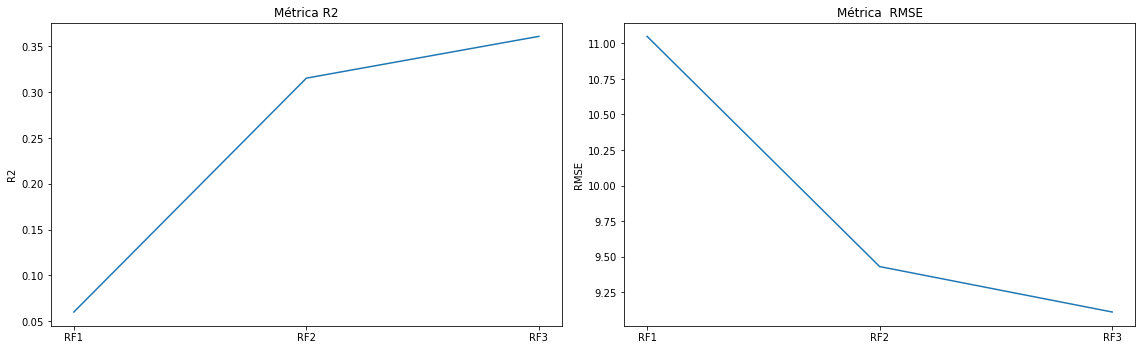

In [17]:
ml.plot_metrics(result.set_index('metrics').T, name_models = ["RF1", "RF2", "RF3"])

Com essas aplicações, verificamos que RF3 utilizando 30 dias de dados, tem o melhor resultado. Portanto, para os modelos SVM e MLP vamos testar o resultado apenas com a utilização dos 30 dias.

## Aplicando o modelo SVM

In [18]:
# Definições básicas e inicialização da classe
features = np.arange(30)
norm = 1
name_model = "svr1"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("svr")

# Aplicando o melhor parâmetro na base de teste
result_svr1, obs_pred_svr1= ml.test_model("svr")

Best parameters:  {'degree': 2, 'kernel': 'poly'}


## Aplicando o modelo MLP

In [19]:
# Definições básicas e inicialização da classe
features = np.arange(30)
norm = 1
name_model = "mlp1"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("mlp")

# Aplicando o melhor parâmetro na base de teste
result_mlp1, obs_pred_mlp1= ml.test_model("mlp")

/home/mauren/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters:  {'activation': 'tanh', 'random_state': 42, 'solver': 'sgd'}


/home/mauren/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## Comparando os três resultados

In [20]:
result1 = pd.merge(pd.merge(result_rf3, result_svr1, on="metrics"), result_mlp1, on="metrics")

In [21]:
result1.round(2)

,metrics,values_random_forest_rf3,values_svr_svr1,values_mlp_mlp1
0,R2,0.36,0.38,0.39
1,MSE,83.02,80.40,79.41
2,RMSE,9.11,8.97,8.91
3,MAE,7.08,6.94,6.96


A diferença é bem pequena entre os três modelos utilizando os 30 dias de dados.

## Aplicando seleção de características

Outro item importante que vamos investigar um pouco é a seleção de características. Aqui vamos abordar um método baseado em impurezas, utilizamos a importância Gini. Quanto mais alto mais importante é o recurso. O método foi utlizado através do modelo Randon Forest.

Outros métodos de seleção de recursos podem ser utilizados, mas faremos uma versão simplista, apenas para verificação do comportamento dos resultados.

Dos 30 dias da base, vamos escolher apenas 5 para a entrada no modelo e observar o comportamento nos modelos propostos.

In [22]:
# Separando o conjunto em treino e teste
X_train = data_features[data_features.index<'2019-01-01'].values[:,1:]
Y_train = data_features[data_features.index<'2019-01-01'].values[:,0]

# Usando o Random Forest com parâmetros default. 
forest = RandomForestRegressor(random_state=42)
forest.fit(X_train, Y_train)

# Verificando a importância das características
importances = forest.feature_importances_

# Ordenando a importância da menor para maior
sorted_idx = importances.argsort()

# Verificando as 5 características mais importantes que iremos utilizar
sorted_idx[-5:]

array([ 0, 13, 20,  6, 27])

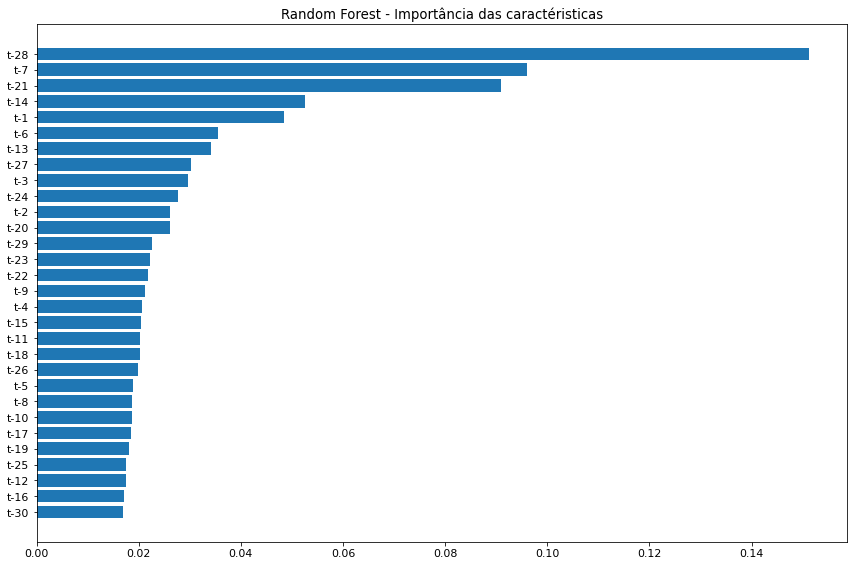

In [23]:
# Plotando a importância das características para melhor visualização

feature_names = data_features.columns[1:]
y_ticks = np.arange(0, 30)
fig, ax = plt.subplots(figsize=(12,8))
ax.barh(y_ticks, importances[sorted_idx][0:30])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names[sorted_idx])
ax.set_title("Random Forest - Importância das caractéristicas")
fig.tight_layout()
plt.show()

### Aplicação do Random Forest com as características selecionas (RF4)

Aqui utilizamos as 5 caracteristicas selecionas: t-1, t-7, t-14, t-21 e t-28

In [24]:
# Definições básicas e inicialização da classe
features = importances.argsort()[-5:]
norm = 1
name_model = "rf4"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("random_forest")

# Aplicando o melhor parâmetro na base de teste
result_rf4, obs_pred_rf4= ml.test_model("random_forest")

Best parameters:  {'max_depth': 5, 'min_samples_split': 20, 'n_estimators': 80, 'random_state': 42}


### Aplicação do SVM com as características selecionas (SVM2)

In [25]:
# Definições básicas e inicialização da classe
features = importances.argsort()[-5:]
norm = 1
name_model = "svr2"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("svr")

# Aplicando o melhor parâmetro na base de teste
result_svr2, obs_pred_svr2= ml.test_model("svr")

Best parameters:  {'degree': 2, 'kernel': 'rbf'}


### Aplicação do MLP com as características selecionas (MLP2)

In [26]:
# Definições básicas e inicialização da classe
features = importances.argsort()[-5:]
norm = 1
name_model = "mlp2"
ml = Model(data_features, features, name_model, norm=norm)

# Treinando o modelo e buscando os melhores parâmetros
ml.search_model("mlp")

# Aplicando o melhor parâmetro na base de teste
result_mlp2, obs_pred_mlp2= ml.test_model("mlp")

/home/mauren/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Best parameters:  {'activation': 'relu', 'random_state': 42, 'solver': 'adam'}


/home/mauren/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:582: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [27]:
result2 = pd.merge(pd.merge(result_rf4, result_svr2, on="metrics"), result_mlp2, on="metrics")

In [28]:
result2.round(2)

,metrics,values_random_forest_rf4,values_svr_svr2,values_mlp_mlp2
0,R2,0.36,0.36,0.36
1,MSE,83.25,83.56,83.31
2,RMSE,9.12,9.14,9.13
3,MAE,7.11,7.15,7.14


Comparando os resultados, verificamos que diminuir o número de características utilizando as mais relevantes, neste caso, afetou o resultado dos modelos minimamente. Isso era esperado, visto que no método utilizado a soma das importancias de todas as caracteristicas é 1, assim, é claro que utilizando apenas algumas variáveis, a explicação do conhecimento desejado é reduzido.

Adicionar características não significa que o modelo sempre vai melhorar. É necessário pesquisar maneiras para selecionar os atributos mais relevantes, de tal forma que as métricas de avaliação utilizadas melhorem ou, ao menos, se mantenham no mesmo nível.

Essa busca por equilíbrio deve sempre ser levada em consideração.

### Por fim, vamos ao plot dos resultados...

Para melhor visualização do comportamento da previsão, fazemos o plot dos resultados. Os modelos aqui plotados são Random Forest, SVR e MLP com a utilização de t-1 até t-30.

In [29]:
# Plot dos dados de Reais e Previstos

# Definindo valores para auxiliar no plot
X_train = data_features[data_features.index<'2019-01-01'].index.values
Y_train = data_features[data_features.index<'2019-01-01'].values[:,0]
x_test = data_features[data_features.index>='2019-01-01'].index.values
y_test = data_features[data_features.index>='2019-01-01'].values[:,0]

# Criando a função de plot
def plot_result(model, X_train, Y_train, x_test, y_model, y_pred_model):
    plt.figure(figsize=(18, 8))
    plt.plot(X_train, Y_train,label='Treino')
    plt.plot(x_test, y_model, label='Teste')
    plt.plot(x_test, y_pred_model,label='Previsão')
    plt.xlabel("Tempo")
    plt.ylabel("Número de acidentes diário")
    plt.title("Resultados com o modelo %s" %(model))
    plt.legend()
    plt.show()

## Random Forest

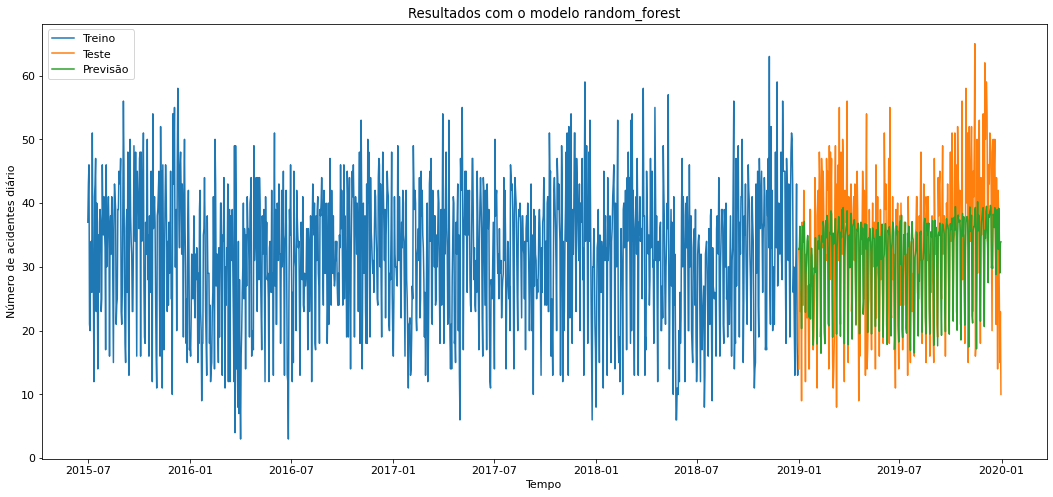

In [30]:
plot_result('random_forest', X_train, Y_train, x_test, obs_pred_rf4["test"], obs_pred_rf4["pred_random_forest_rf4"])

## SVM

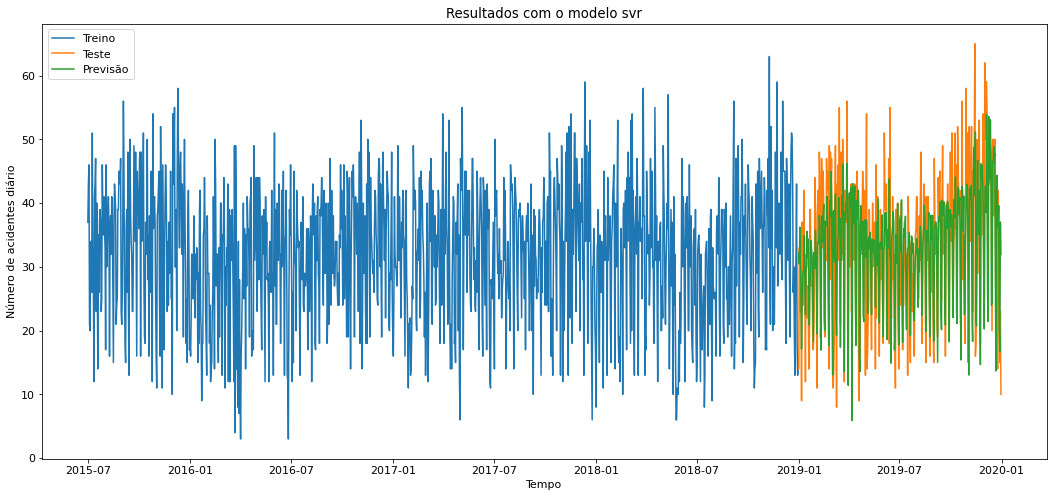

In [31]:
plot_result('svr', X_train, Y_train, x_test, obs_pred_svr1["test"], obs_pred_svr1["pred_svr_svr1"])

## MLP

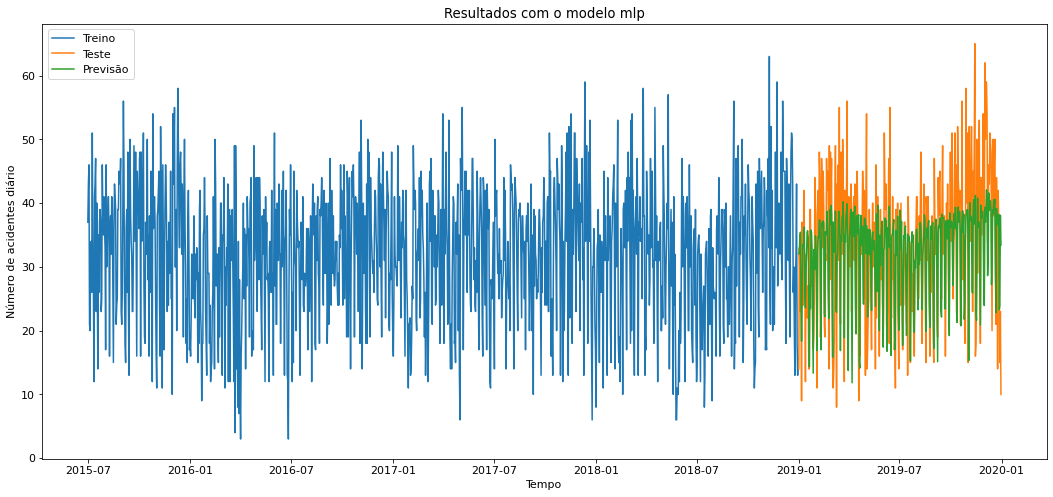

In [32]:
plot_result('mlp', X_train, Y_train, x_test, obs_pred_mlp1["test"], obs_pred_mlp1["pred_mlp_mlp1"])

## Considerações Finais

A exploração inicial permitiu entender os dados e trata-los de uma maneira adequada. Mas ainda assim ficam questões que deveriam ser mais exploradas para se obter um modelo com melhor desempenho. Por exemplo, trabalhar com outras características não usadas nos modelos propostos (utilizar os dias da semana, o período que ocorrem mais acidentes, número de vítimas, entre outros).

Também podem ser aplicadas outras técnicas para fazer a seleção de características. Novos modelos podem ser explorados, e inseridos na busca de parâmetros.Também pode-se buscar uma aplicação com rede neurais recorrentes, que vem ganhando frente no contexto de séries temporais.

Modelos usuais baseados em técnicas estatística também podem ser explorados, por exemplo, modelo Arima.

O que foi feito é apenas uma exploração inicial, com possíveis tratamentos e abordagens, muitas questões podem ser vistas e revistas para se chegar a um modelo com melhor desempenho.